In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 데이터 로드
url_red = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
url_white = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# CSV 파일을 데이터프레임으로 읽기
data_red = pd.read_csv(url_red, sep=';')
data_white = pd.read_csv(url_white, sep=';')

# 데이터 합치기
data_red['type'] = 'red'
data_white['type'] = 'white'
data = pd.concat([data_red, data_white], axis=0)

# 특성과 레이블 분리
X = data.drop(columns=['type', 'quality'])
y = data['quality']

# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


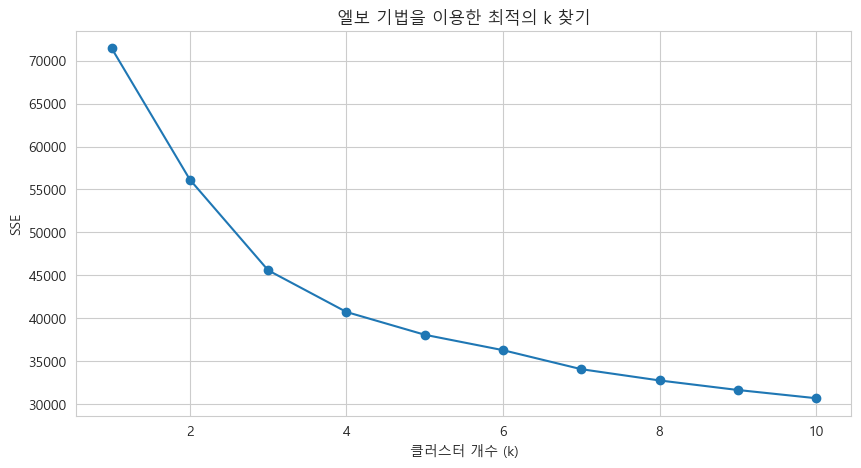

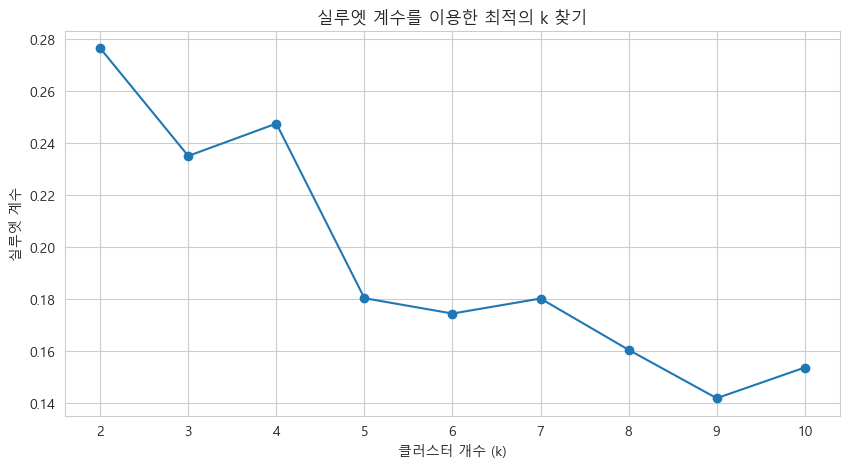

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.font_manager as fm

# 폰트 경로 설정
# font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font_path= "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 폰트 경로
font_prop = fm.FontProperties(fname=font_path)

# Matplotlib 기본 폰트 설정
plt.rc('font', family=font_prop.get_name())

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 엘보 기법
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('클러스터 개수 (k)')
plt.ylabel('SSE')
plt.title('엘보 기법을 이용한 최적의 k 찾기')
plt.show()

# 실루엣 계수
silhouette_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('클러스터 개수 (k)')
plt.ylabel('실루엣 계수')
plt.title('실루엣 계수를 이용한 최적의 k 찾기')
plt.show()


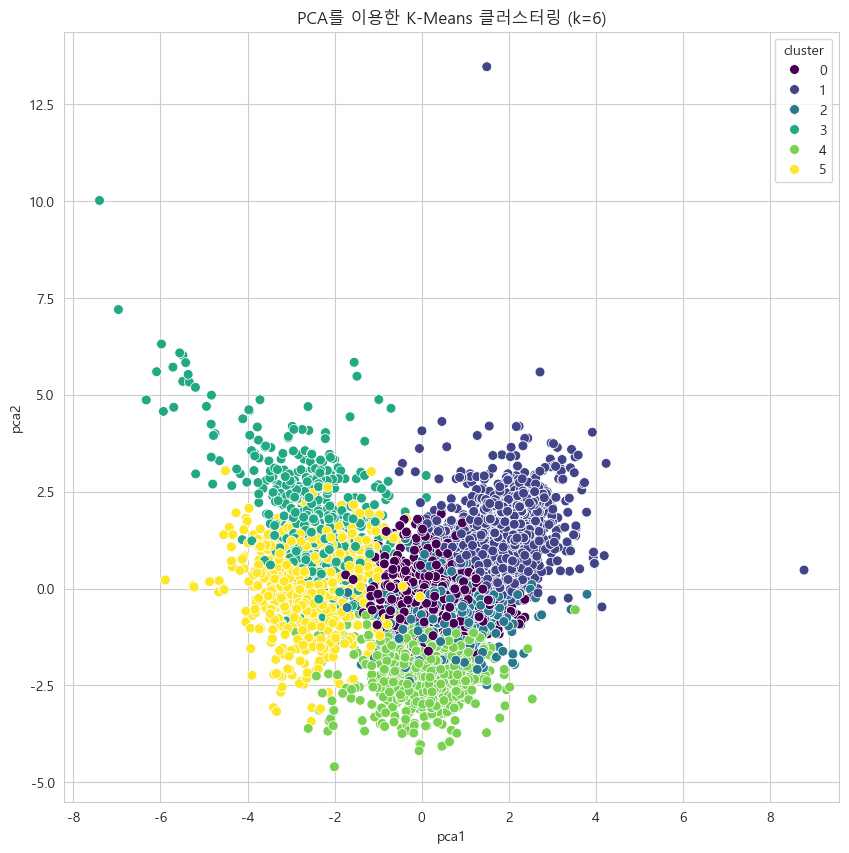

In [3]:
import numpy as np
import seaborn as sns

# 최적의 클러스터 개수 설정 (예: 6)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# 원본 데이터에 클러스터 레이블 추가
data['cluster'] = labels

# 주성분 분석(PCA)을 통한 2D 시각화
# 차원이 고차원 -> 저차원 차원 축소 기법,
# 예) 특징 와인 등급 영향을 주는 요소 , 독립변수,
# 독립변수, 약 11개. -> 11차원, 분석을 하면, 성능도 나쁘다. ,
# 2개, 3개 정도, 2D, 3D 차원을 축소함. 최대한 원래 값의 특성을 유지 할려고
# 한상태에서, 축소함. -> 좌표 평명에 나타낼수 있음.

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
data['pca1'] = components[:, 0]
data['pca2'] = components[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(data=data, x='pca1', y='pca2', hue='cluster', palette='viridis', s=50)
plt.title(f'PCA를 이용한 K-Means 클러스터링 (k={optimal_k})')
plt.show()


In [4]:
# 샘플 데이터 정의 (예: 임의의 화학적 특성 값)
sample_data = np.array([[7.4, 0.7, 0, 1.9, 0.076, 11, 34, 0.9978, 3.51, 0.56, 9.4]])

# 샘플 데이터 표준화
sample_data_scaled = scaler.transform(sample_data)

# 샘플 데이터 클러스터 예측
sample_label = kmeans.predict(sample_data_scaled)

print(f"샘플 데이터는 클러스터 {sample_label[0]}에 속합니다.")


샘플 데이터는 클러스터 5에 속합니다.


C:\Users\it\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [5]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Adjusted Rand Index (ARI) 계산
ari_score = adjusted_rand_score(data['quality'], data['cluster'])

# Normalized Mutual Information (NMI) 계산
nmi_score = normalized_mutual_info_score(data['quality'], data['cluster'])

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")


Adjusted Rand Index (ARI): 0.0353
Normalized Mutual Information (NMI): 0.0619


In [6]:
# 📌 클러스터 결과를 포함한 데이터 저장
output_file_path = "./wine_clustering_results.csv"
# 📌 필요한 컬럼만 선택
output_data = data[['type', 'quality', 'cluster']]
output_data.to_csv(output_file_path, index=False)

print(f"✅ 클러스터 예측 결과가 포함된 CSV 파일이 저장되었습니다: {output_file_path}")


✅ 클러스터 예측 결과가 포함된 CSV 파일이 저장되었습니다: ./wine_clustering_results.csv


In [7]:
from scipy.stats import mode

# 📌 클러스터별 가장 많이 등장하는 quality 값 찾기
cluster_to_quality = {}
for cluster in sorted(data['cluster'].unique()):
    # 해당 클러스터 내에서 가장 많이 등장하는 quality 값 찾기
    most_common_quality = mode(data[data['cluster'] == cluster]['quality'], keepdims=True).mode[0]
    cluster_to_quality[cluster] = most_common_quality

# 📌 매핑된 클러스터 → 품질 출력
print("📌 클러스터 → 대표 품질 매핑:")
for cluster, quality in cluster_to_quality.items():
    print(f"클러스터 {cluster} → 품질 {quality}")


📌 클러스터 → 대표 품질 매핑:
클러스터 0 → 품질 6
클러스터 1 → 품질 5
클러스터 2 → 품질 6
클러스터 3 → 품질 6
클러스터 4 → 품질 6
클러스터 5 → 품질 5
